The method I had practiced with producted no excess in the dijet invariant mass. This dataset was different than the first two black boxes with larger parton multiplicies within the jets and less missing transverse energy, for example. I tried looking for an excess in the transverse mass of a jet + invisible, but don't have a good background model for that

# Load Data

In [1]:
import os
import numpy as np
import pandas as pd

In [2]:
data_path = '/Users/christopherwmurphy/Documents/projects/lhc_olympics/LHC-Olympics-2020/data_processed'

In [3]:
df_bg = pd.read_hdf(os.path.join(data_path, 'processed_eventsLHCO2020backgroundMCPythia.h5'), key='processed')

In [4]:
df_3 = pd.read_hdf(os.path.join(data_path, 'processed_eventsLHCO2020BlackBox3.h5'), key='processed')

In [5]:
df_3['etmiss'] = np.linalg.norm(df_3[['etmiss_x', 'etmiss_y']], axis=1)
df_bg['etmiss'] = np.linalg.norm(df_bg[['etmiss_x', 'etmiss_y']], axis=1)

In [6]:
def transverse_mass(df, mass, pt, phi):
    etvis = (df[pt]**2 + df[mass]**2)**0.5
    ptvis_dot_ptmiss = df[pt] * (np.cos(df[phi]) * df['etmiss_x'] + np.sin(df[phi]) * df['etmiss_y'])
    return (df[mass]**2 + 2 * (etvis * df['etmiss'] - ptvis_dot_ptmiss))**0.5

In [7]:
df_3['mt_1'] = transverse_mass(df_3, 'mass_1', 'pt_1', 'phi_1')
df_3['mt_2'] = transverse_mass(df_3, 'mass_2', 'pt_2', 'phi_2')
df_bg['mt_1'] = transverse_mass(df_bg, 'mass_1', 'pt_1', 'phi_1')
df_bg['mt_2'] = transverse_mass(df_bg, 'mass_2', 'pt_2', 'phi_2')

# Outlier Detection

Using these features is not how I drew it up, but this dataset proved to be different than the others

In [8]:
od_cols = ['multiplicity_1', 'fragmentation_1', 'multiplicity_2', 'fragmentation_2',
           'etmiss', 'mass_1', 'mass_2', 'delta_phi_jj',
           'tau21_1', 'tau21_2', 'tau43_1', 'tau43_2']

In [9]:
from pyod.models.pca import PCA
from sklearn.preprocessing import QuantileTransformer

In [10]:
qt3 = QuantileTransformer()
X_od3 = qt3.fit_transform(df_3[od_cols])
pca_3 = PCA(n_components=11, n_selected_components=1)
pca_3.fit(X_od3)
df_3['pca'] = pca_3.decision_scores_

In [11]:
qt_bg = QuantileTransformer()
X_od_bg = qt_bg.fit_transform(df_bg[od_cols])
pca_bg = PCA(n_components=11, n_selected_components=1)
pca_bg.fit(X_od_bg)
df_3['pca_bg'] = pca_bg.decision_function(X_od3)
df_bg['pca'] = pca_bg.decision_scores_

In [12]:
od_quantiles = [0.0, 0.7, 0.9, 0.97, 0.99, 0.997, 0.999]

In [14]:
import matplotlib.pyplot as plt

In [15]:
%matplotlib notebook

plt.rcParams['savefig.dpi'] = 75
plt.rcParams['figure.autolayout'] = False
plt.rcParams['axes.labelsize'] = 18
plt.rcParams['axes.titlesize'] = 16
plt.rcParams['font.size'] = 16
plt.rcParams['legend.fontsize'] = 16
plt.rcParams['xtick.color'] = 'k'
plt.rcParams['ytick.color'] = 'k'
plt.rcParams['text.usetex'] = True
plt.rcParams['font.family'] = "sans-serif"
plt.rcParams['font.serif'] = "cm"

There is no excess in the dijet invariant mass

<IPython.core.display.Javascript object>


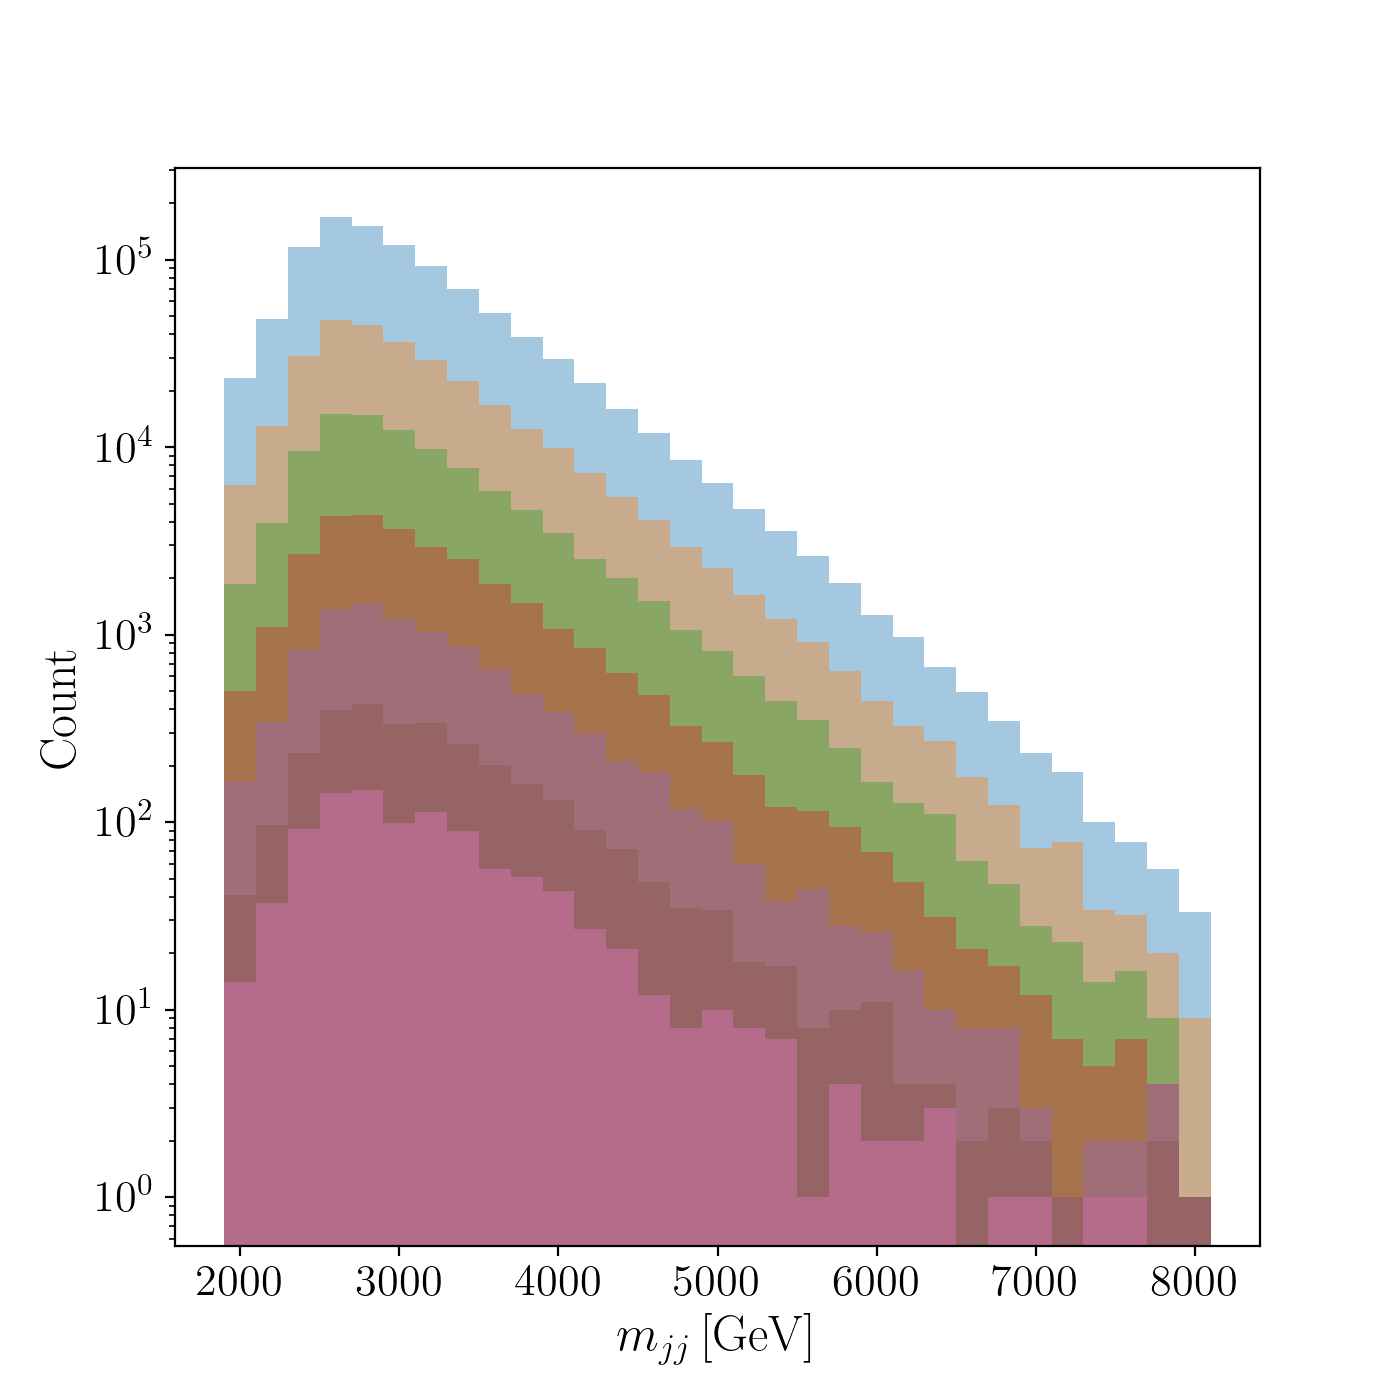

In [16]:
plt.figure(1, figsize=(7, 7))
for q in od_quantiles:
    plt.hist(df_3[df_3['pca'] > df_3['pca'].quantile(q)]['mass_jj'], alpha=0.4, bins=np.arange(1900, 8300, 200))
plt.yscale('log')
plt.xlabel(r'$m_{jj}\, \rm [GeV]$')
plt.ylabel(r'$\rm Count$')
plt.show()

Maybe there's an excess in the transverse mass of the 2nd jet plus the missing transverse energy? The blue is the QCD dataset and the orange is BlackBox3

<IPython.core.display.Javascript object>


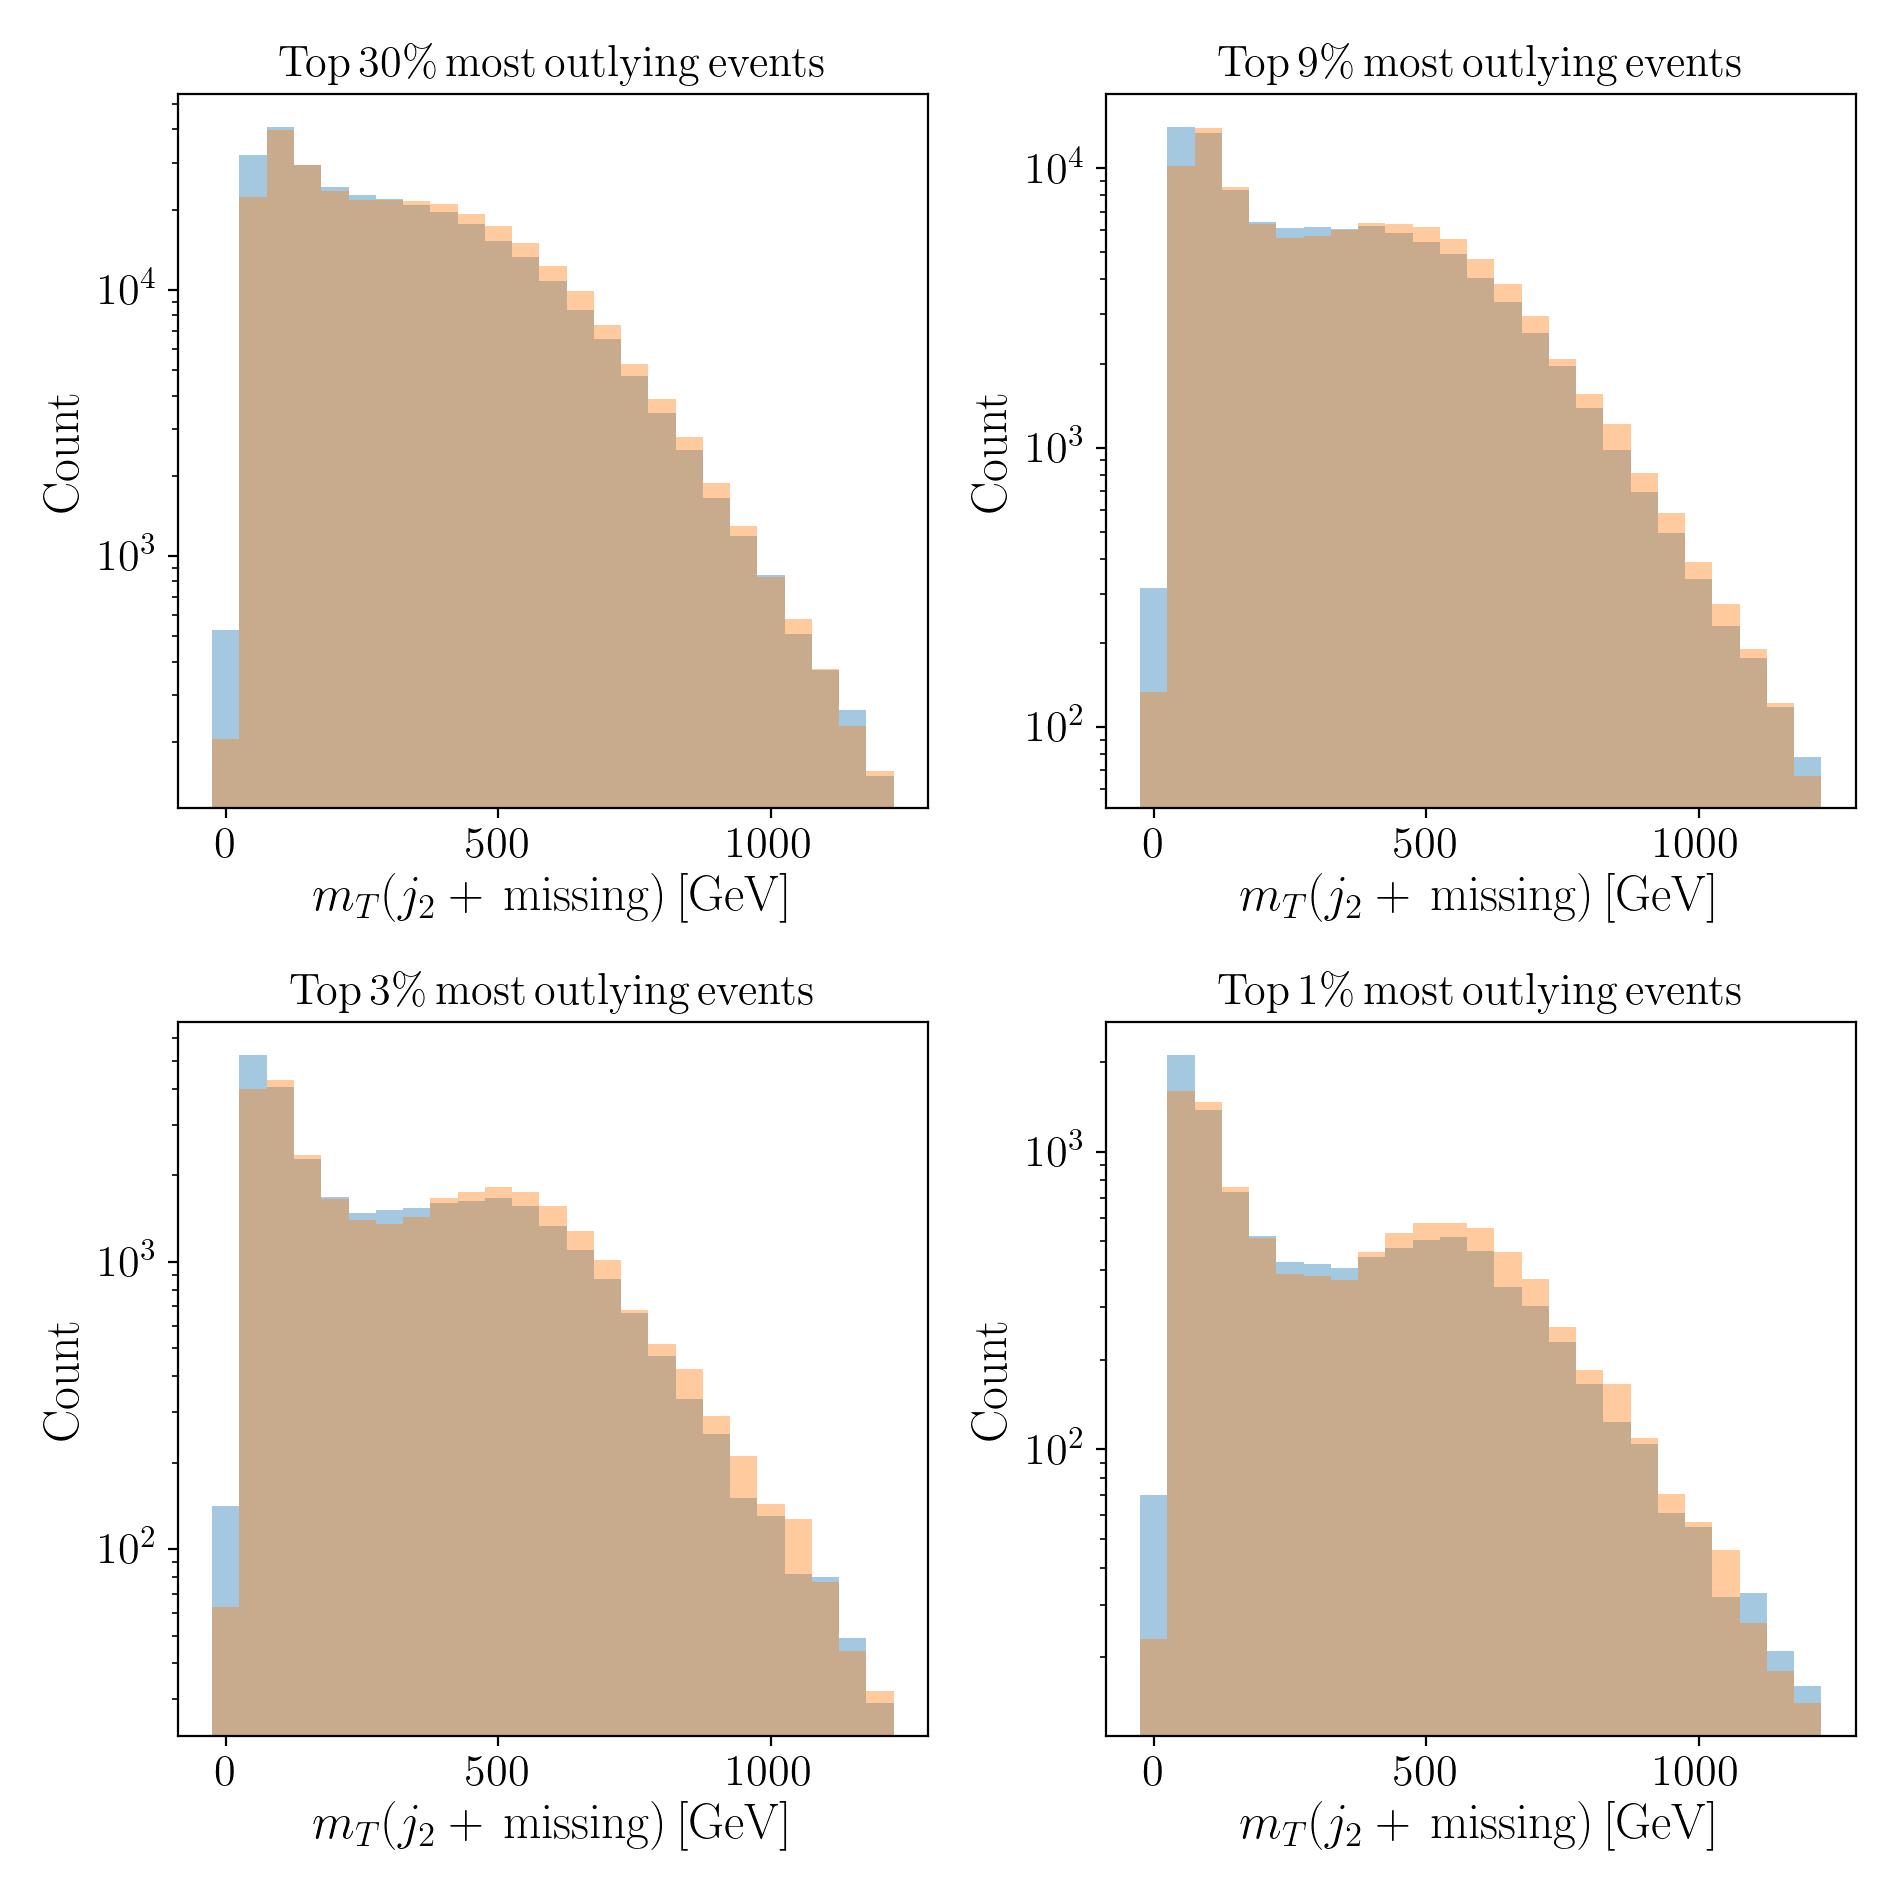

In [21]:
plt.figure(2, figsize=(9.5, 9.5))

mt_bins = np.arange(-25, 1275, 50)
mt_quantiles = [0.7, 0.9, 0.97, 0.99]

for i in range(len(mt_quantiles)):
    plt.subplot(2, 2, i+1)
    plt.hist(df_bg[df_bg['pca'] > df_bg['pca'].quantile(mt_quantiles[i])]['mt_2'], alpha=0.4, bins=mt_bins)
    plt.hist(df_3[df_3['pca'] > df_3['pca'].quantile(mt_quantiles[i])]['mt_2'], alpha=0.4, bins=mt_bins)
    plt.yscale('log')
    plt.xlabel(r'$m_T (j_2 +\, \rm missing)\, [GeV]$')
    plt.ylabel(r'$\rm Count$')
    plt.title(r'$\rm Top\, {}\%\, most\, outlying\, events$'.format(int(100*(1-mt_quantiles[i]))))

plt.tight_layout(True)
plt.show()

But I have no good way to model the background

In [22]:
import sys
sys.path.append('../')
from src.analysis.discovery import GetPValue
from src.analysis import utils

In [23]:
gpv = GetPValue()

<IPython.core.display.Javascript object>


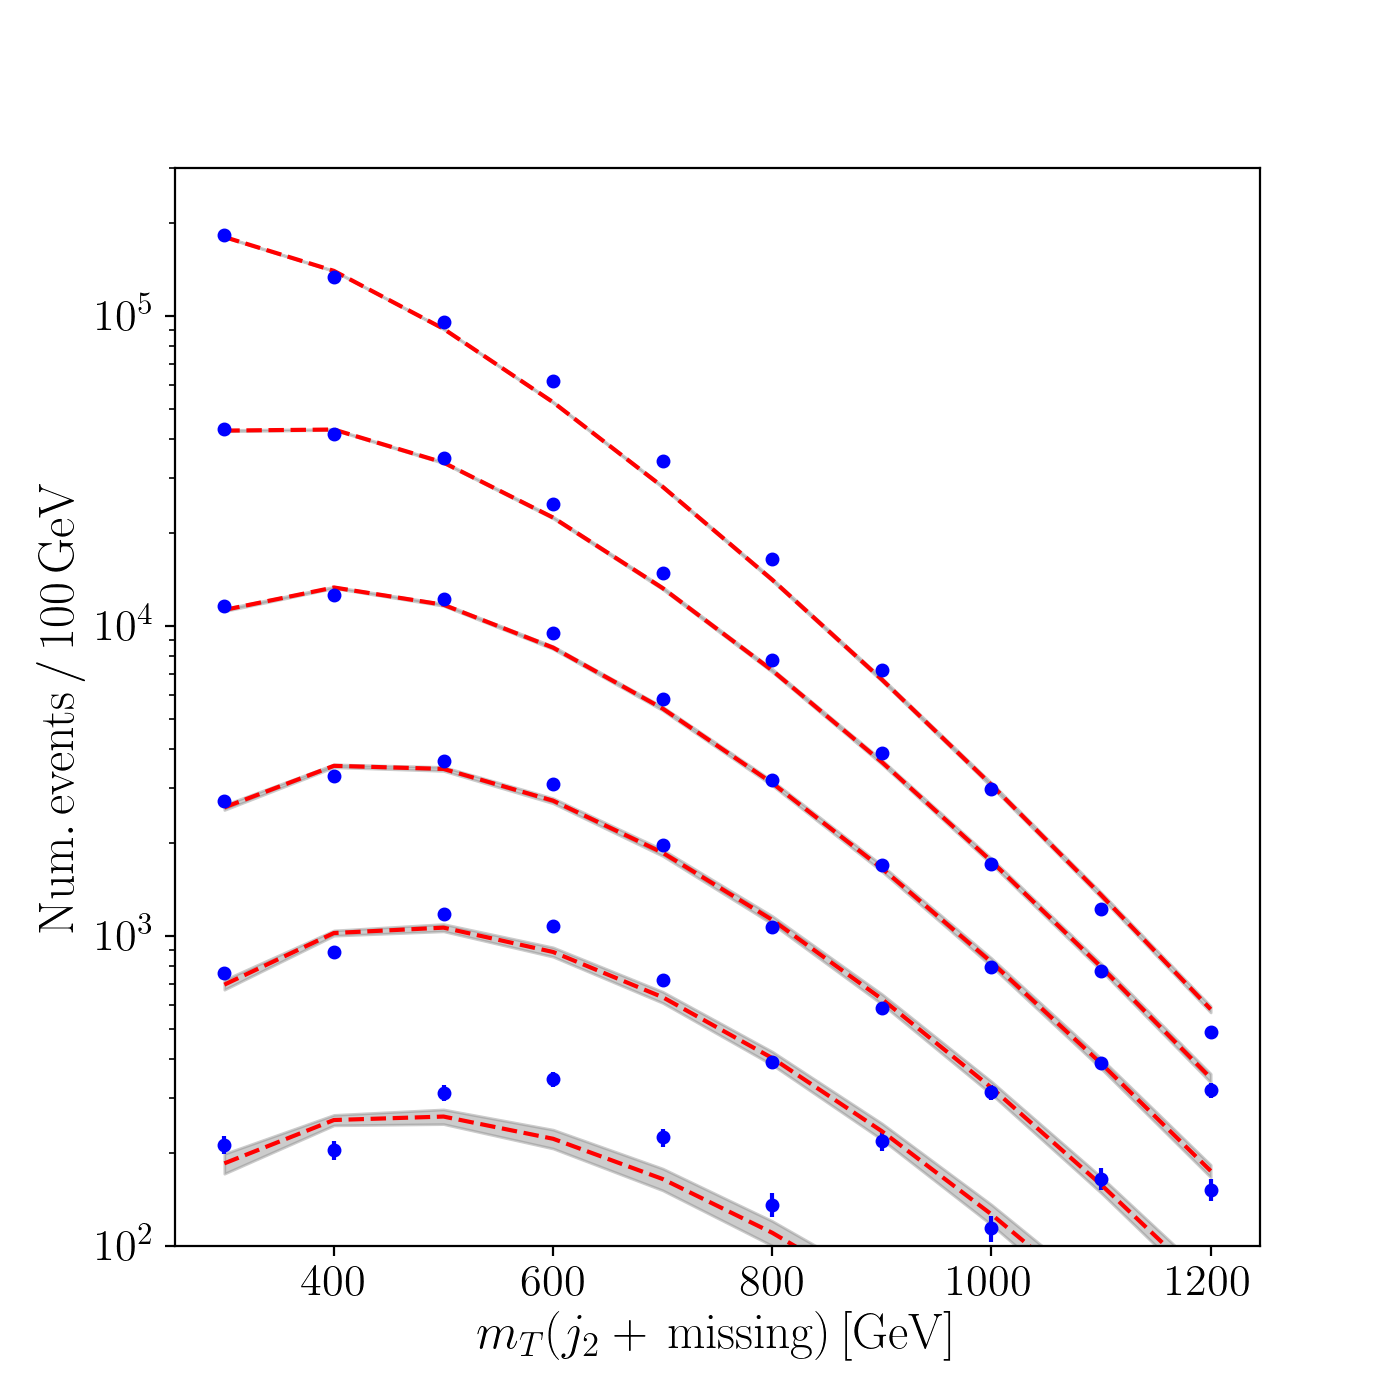

INFO:root:Fit params:
INFO:root:72384003195.3594
INFO:root:127.69852161232028
INFO:root:-2.6332343110219476
INFO:root:Number of expected events = 104655.43558674474
INFO:root:Number of observed events = 122294.0
INFO:root:Numerator:
INFO:root:fun = -1309129.8111548503
INFO:root:jac = [-0.13969839]
INFO:root:nfev = 20
INFO:root:nit = 3
INFO:root:status = 0
INFO:root:message = b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
INFO:root:x = [1647.47218898]
INFO:root:success = True
INFO:root:hess_inv = <1x1 LbfgsInvHessProduct with dtype=float64>
INFO:root:Denominator:
INFO:root:fun = -1310279.7966956976
INFO:root:jac = [0. 0.]
INFO:root:hess_inv = [[ 382861.80908449 -468857.95853414]
 [-468857.95853414  578014.3591065 ]]
INFO:root:nfev = 132
INFO:root:njev = 33
INFO:root:status = 0
INFO:root:success = True
INFO:root:message = Optimization terminated successfully.
INFO:root:x = [  566.28361681 16940.97042053]
INFO:root:nit = 11
INFO:root:Zval = 47.95801373800408
INFO:root:p0 = 0.0
INFO:r

In [25]:
plt.figure(3, figsize=(7, 7))
for q in [0, 0.7, 0.9, 0.97, 0.99, 0.997]:
    hist = np.histogram(df_3[df_3['pca'] > df_3['pca'].quantile(q)]['mt_2'], bins=np.arange(250, 1350, 100))
    ydata = hist[0]
    binvals = hist[1]
    mask = [3, 4, 5, 6, 7]
    try:
        gpv.get_p_value(ydata, binvals, mask, verbose=True, plotfile='show')
    except RuntimeError:
        pass
plt.ylim(10**2, 3*10**5)
plt.title(None)
plt.xlabel(r'$m_T (j_2 +\, \rm missing)\, [GeV]$')
plt.ylabel(r'$\rm Num.\, events\, /\, 100\, GeV$')
plt.show()